In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import json

In [2]:
from torchvision.transforms import transforms
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/SMAI/Understanding_CNN"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SMAI/Understanding_CNN


In [4]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), #0
            nn.ReLU(inplace=True), #1
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True), #2
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), #3
            nn.ReLU(inplace=True), #4
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True), #5
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #6
            nn.ReLU(inplace=True), #7
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #8
            nn.ReLU(inplace=True), #9
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #10
            nn.ReLU(inplace=True), #11
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) #12
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=1000, bias=True)
        )

        self.conv_i = [0,3,6,8,10]
        

        self.feature_maps = OrderedDict()
        self.switches = OrderedDict()
        self.init_weights()

    def init_weights(self):
    
        alexnet_pretrained = models.alexnet(pretrained=True)
        
        for idx, layer in enumerate(alexnet_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[idx].weight.data = layer.weight.data
                self.features[idx].bias.data = layer.bias.data
        
        for idx, layer in enumerate(alexnet_pretrained.classifier):
            if isinstance(layer, nn.Linear):
                self.classifier[idx].weight.data = layer.weight.data
                self.classifier[idx].bias.data = layer.bias.data

    def forward(self, x):

        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                # self.pool_locs[idx] = location
            else:
                x = layer(x)
        
        # reshape to (1, 512 * 7 * 7)
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output


In [5]:
class AlexNetDeconv(nn.Module):

    def __init__(self):
        super(AlexNetDeconv, self).__init__()

        self.features = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #0
            nn.ReLU(inplace=True), #1
            nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #2

            nn.ReLU(inplace=True), #3
            nn.ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #4

            nn.ReLU(inplace=True), #5
            nn.ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #6

            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #7
            nn.ReLU(inplace=True), #8
            nn.ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), #9

            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #10
            nn.ReLU(inplace=True), #11
            nn.ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) #12

        )

        self.layer_mapping = {5:0, 4:3, 3:5, 2:7, 1:10}

        self.unpool2pool_indices = {0:12, 7:5, 10:2}
        self.conv2deconv_indices = {0:12, 3:9, 6:6, 8:4, 10:2}

        self.init_weights()

    def init_weights(self):
        alexnet_pretrained = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data

    def forward(self, x, layer, activation_idx, switches):
        start_idx = self.layer_mapping[layer]
        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                # print(idx, x.shape,switches[self.unpool2pool_indices[idx]].shape)
                x = self.features[idx](x, switches[self.unpool2pool_indices[idx]])
            else:
                # print(idx, x.shape)
                x = self.features[idx](x)
        return x
    

In [6]:
def load_images(img_path):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    return img

In [7]:
def store(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.switches[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [8]:
def visualize_layer(layer_num, conv, deconv):
    layer_mapping = {5:12, 4:9, 3:7, 2:5, 1:2}
    layer = layer_mapping[layer_num]

    num_feat = conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    # print(max_activation)
    # print("input activation", new_feat_map.shape)
    deconv_output = deconv(new_feat_map, layer_num, mark, conv.switches)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [10]:
def normalise_img(img):

    transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    img = transform(img)
    return img

def predict(model, image, labels):
    _, index = model(image).data[0].max(0)
    # print(index)
    # print(type(index))
    # print(index.shape)
    return str(index.item()), labels[str(index.item())][1]

def process_images(img):
    img = cv2.resize(img, (224, 224))
    img = normalise_img(img)
    img = torch.unsqueeze(img,0)
    return img

model = models.alexnet(pretrained=True)
labels = json.load(open('labels/imagenet_class_index.json'))

def visualise_for_image(img):

    img_orig = img
    img = process_images(img)
    pred = predict(model, img, labels)
    conv = AlexNet()
    conv.eval()
    store(conv)
    conv_output = conv(img)
    pool_locs = conv.switches

    print('Predicted:', pred)

    deconv = AlexNetDeconv()
    deconv.eval()
    plt.figure(figsize=(40,40), dpi=80)
    img = cv2.resize(img_orig, (224, 224))
    plt.subplot(4,4,1)
    plt.imshow(img[:,:,::-1])
    plt.title("Original")
    plt.axis("off")
    i=2
    for idx, layer in enumerate([1, 2, 3, 4, 5]):      
        img, activation = visualize_layer(layer, conv, deconv)
        plt.subplot(4,4,i)
        plt.title(f'Layer : {layer}')
        plt.imshow(img)
        plt.axis("off")
        i+=1
    plt.show()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted: ('285', 'Egyptian_cat')


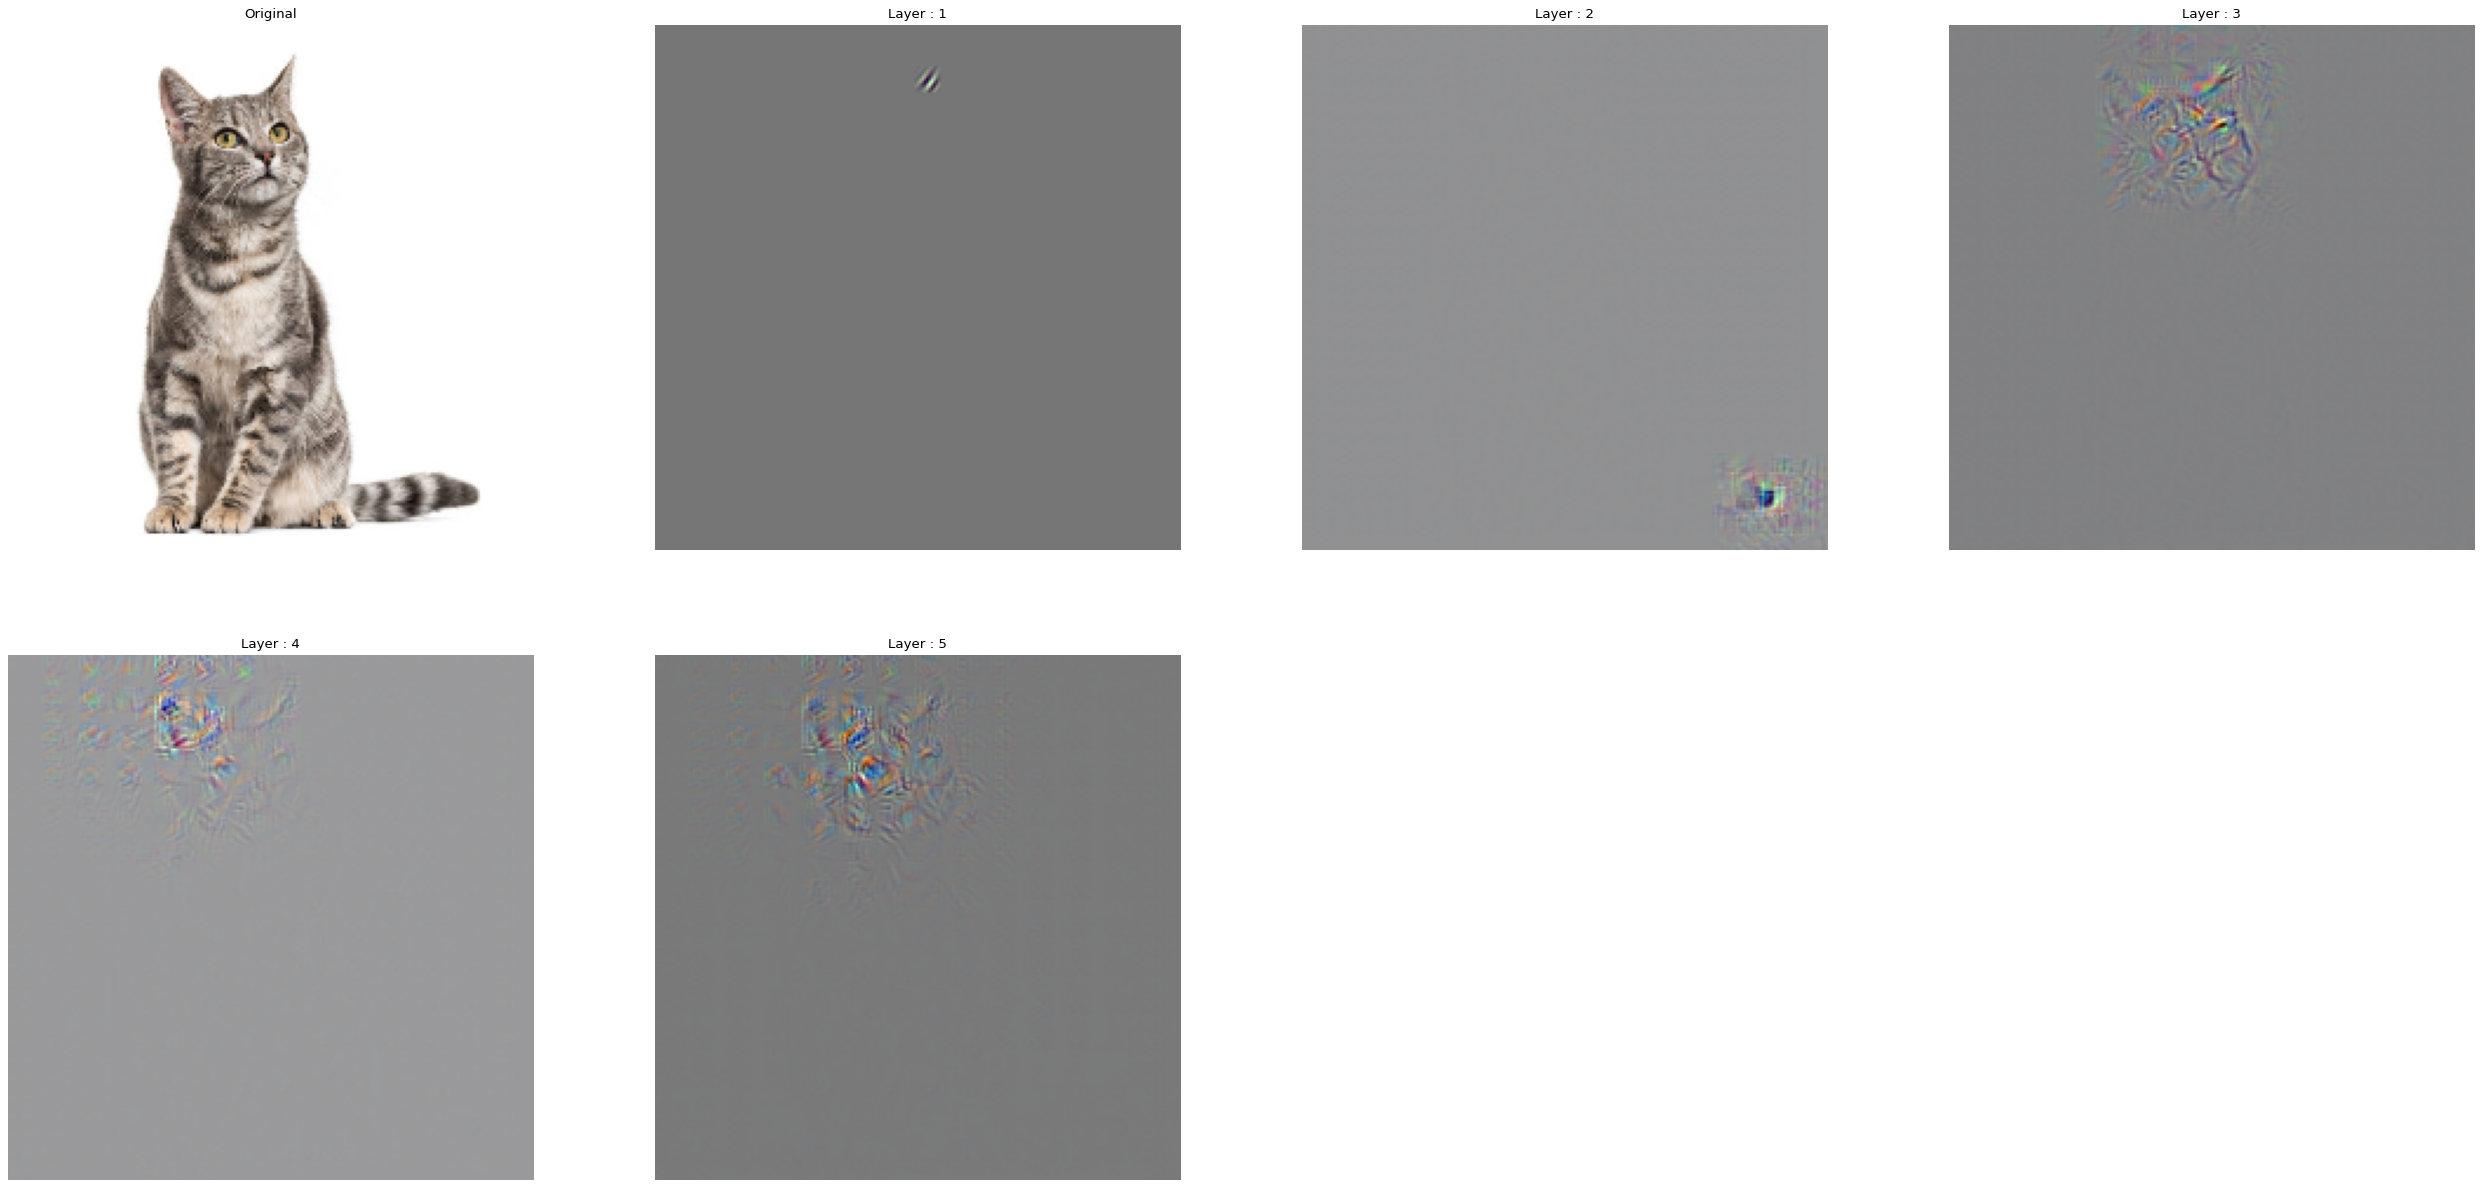

In [11]:
img_orig = cv2.imread('imgs/cat.jpg')
visualise_for_image(img_orig)

Predicted: ('340', 'zebra')


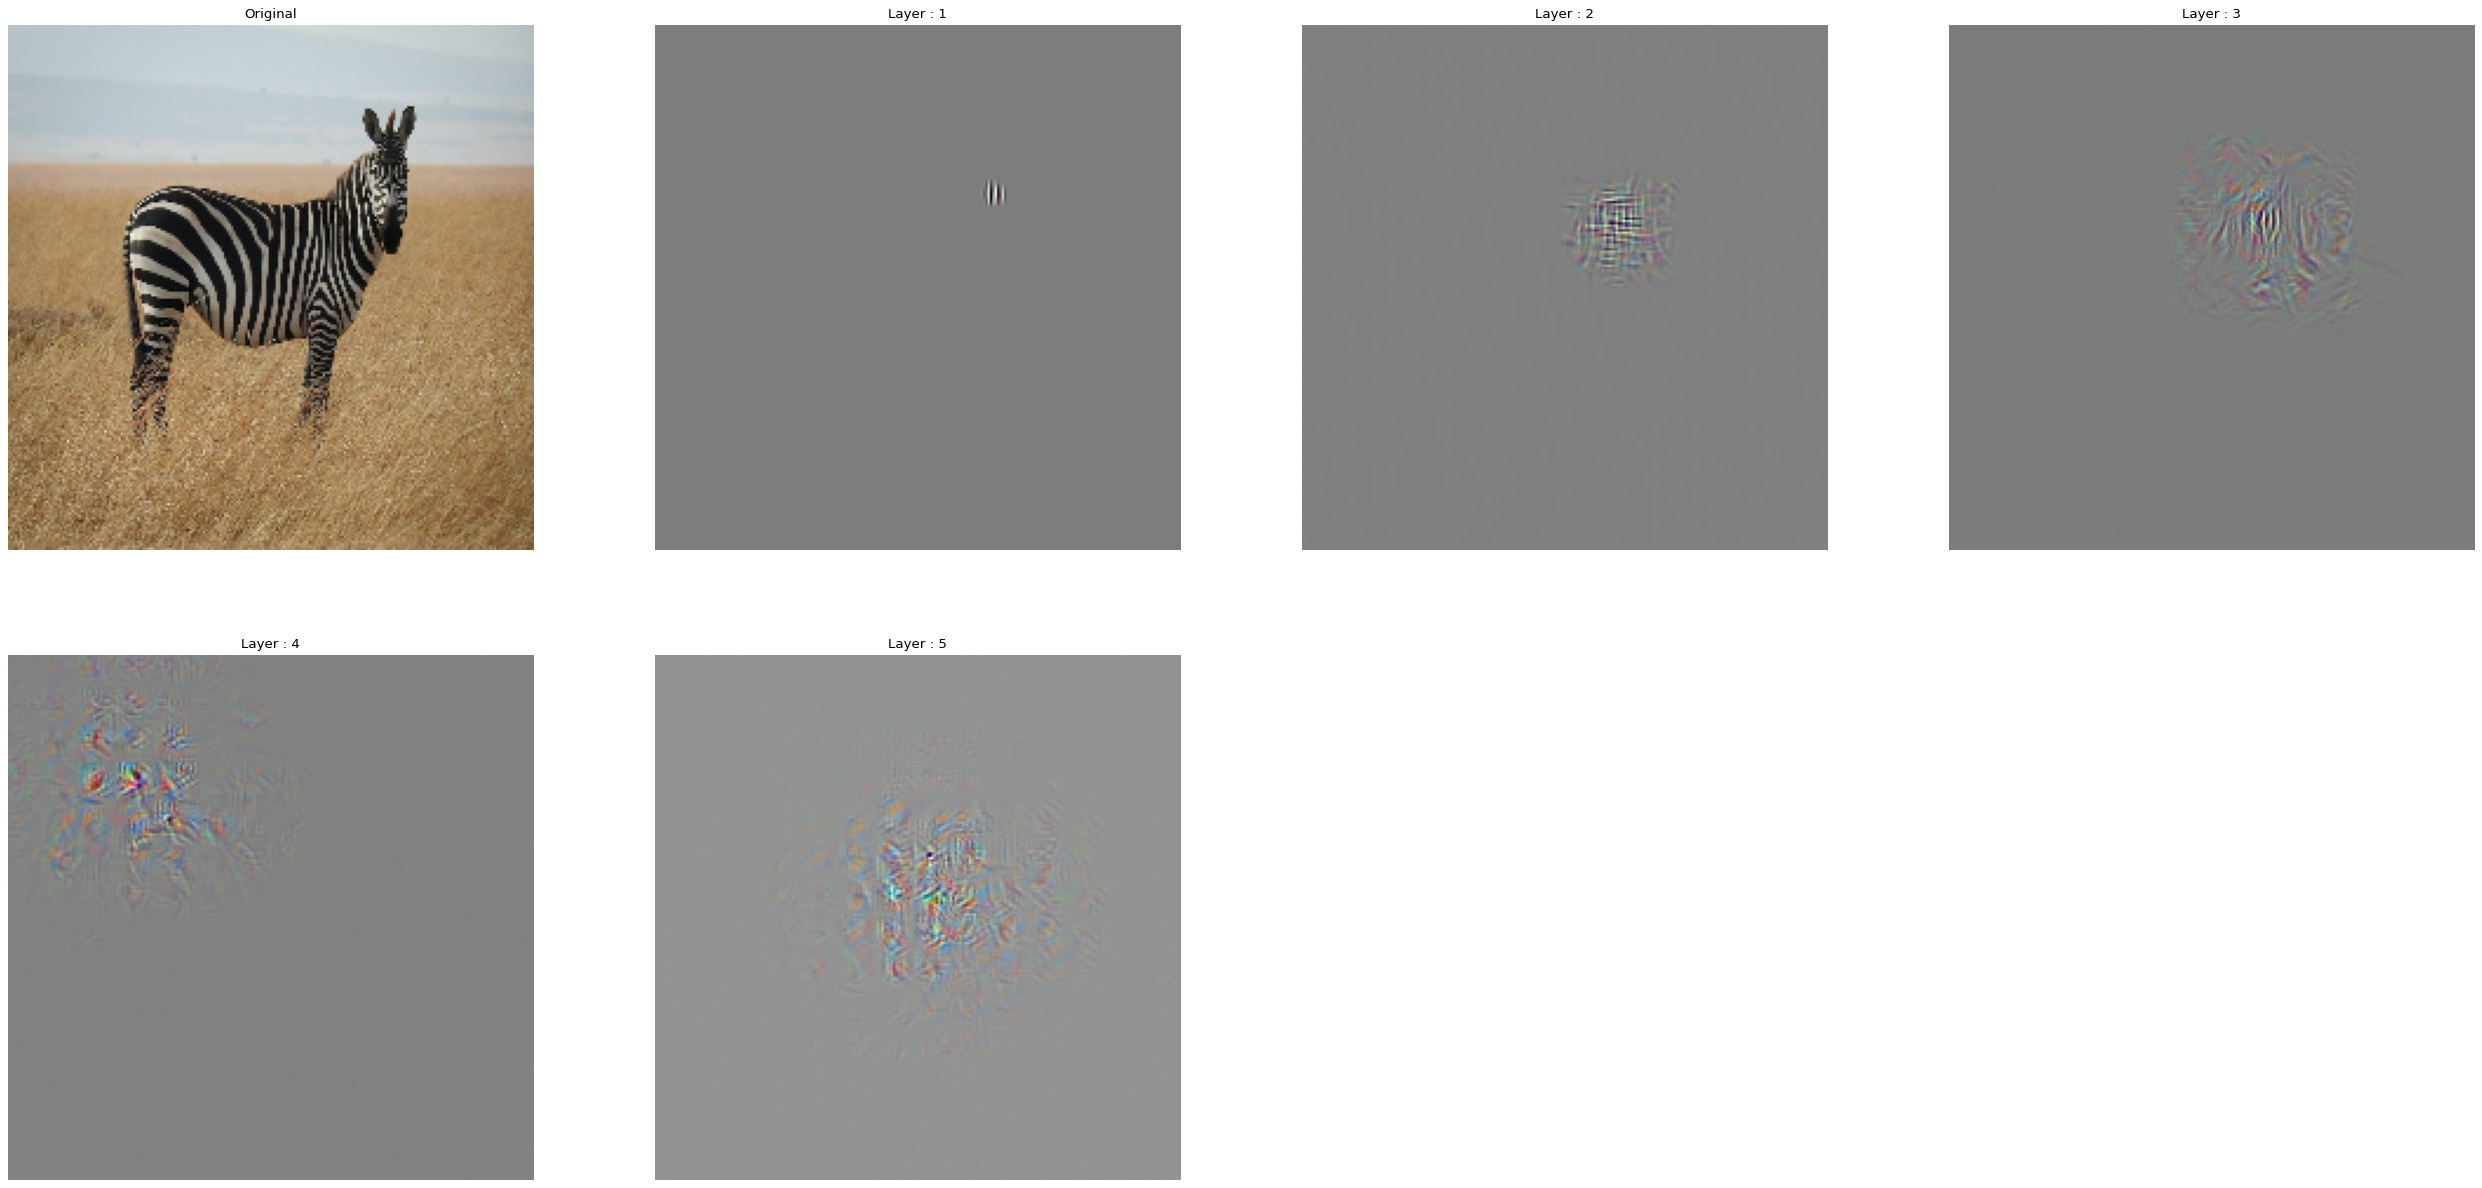

In [16]:
img_orig = cv2.imread('imgs/zebra.jpeg')
visualise_for_image(img_orig)

Predicted: ('749', 'quill')


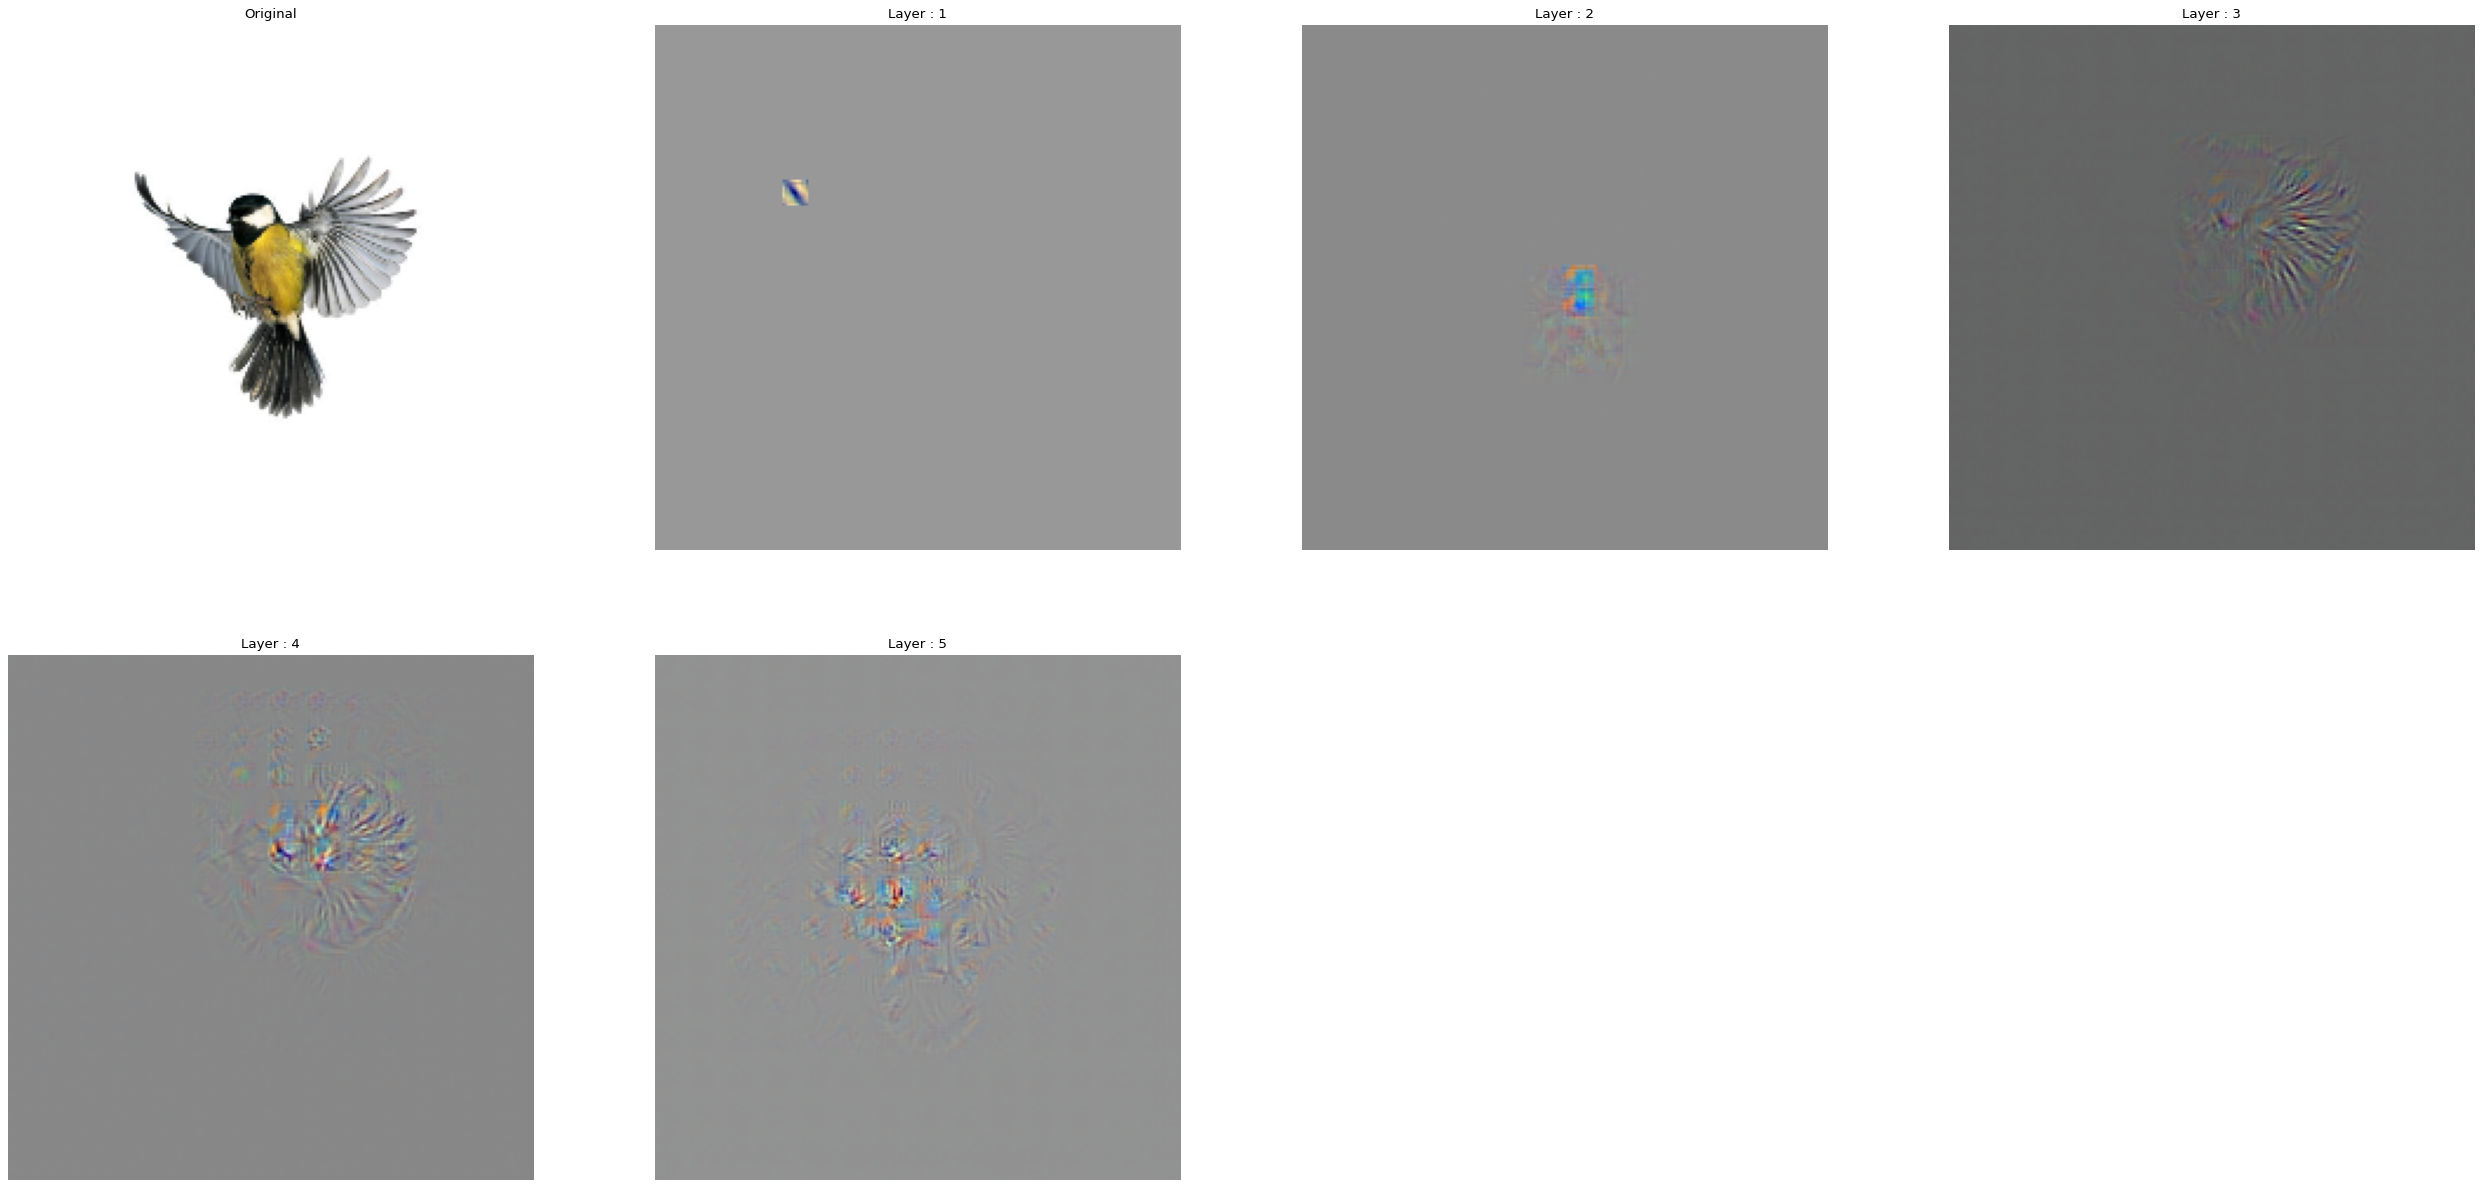

In [12]:
img_orig = cv2.imread('imgs/bird.jpg')
visualise_for_image(img_orig)

Predicted: ('257', 'Great_Pyrenees')


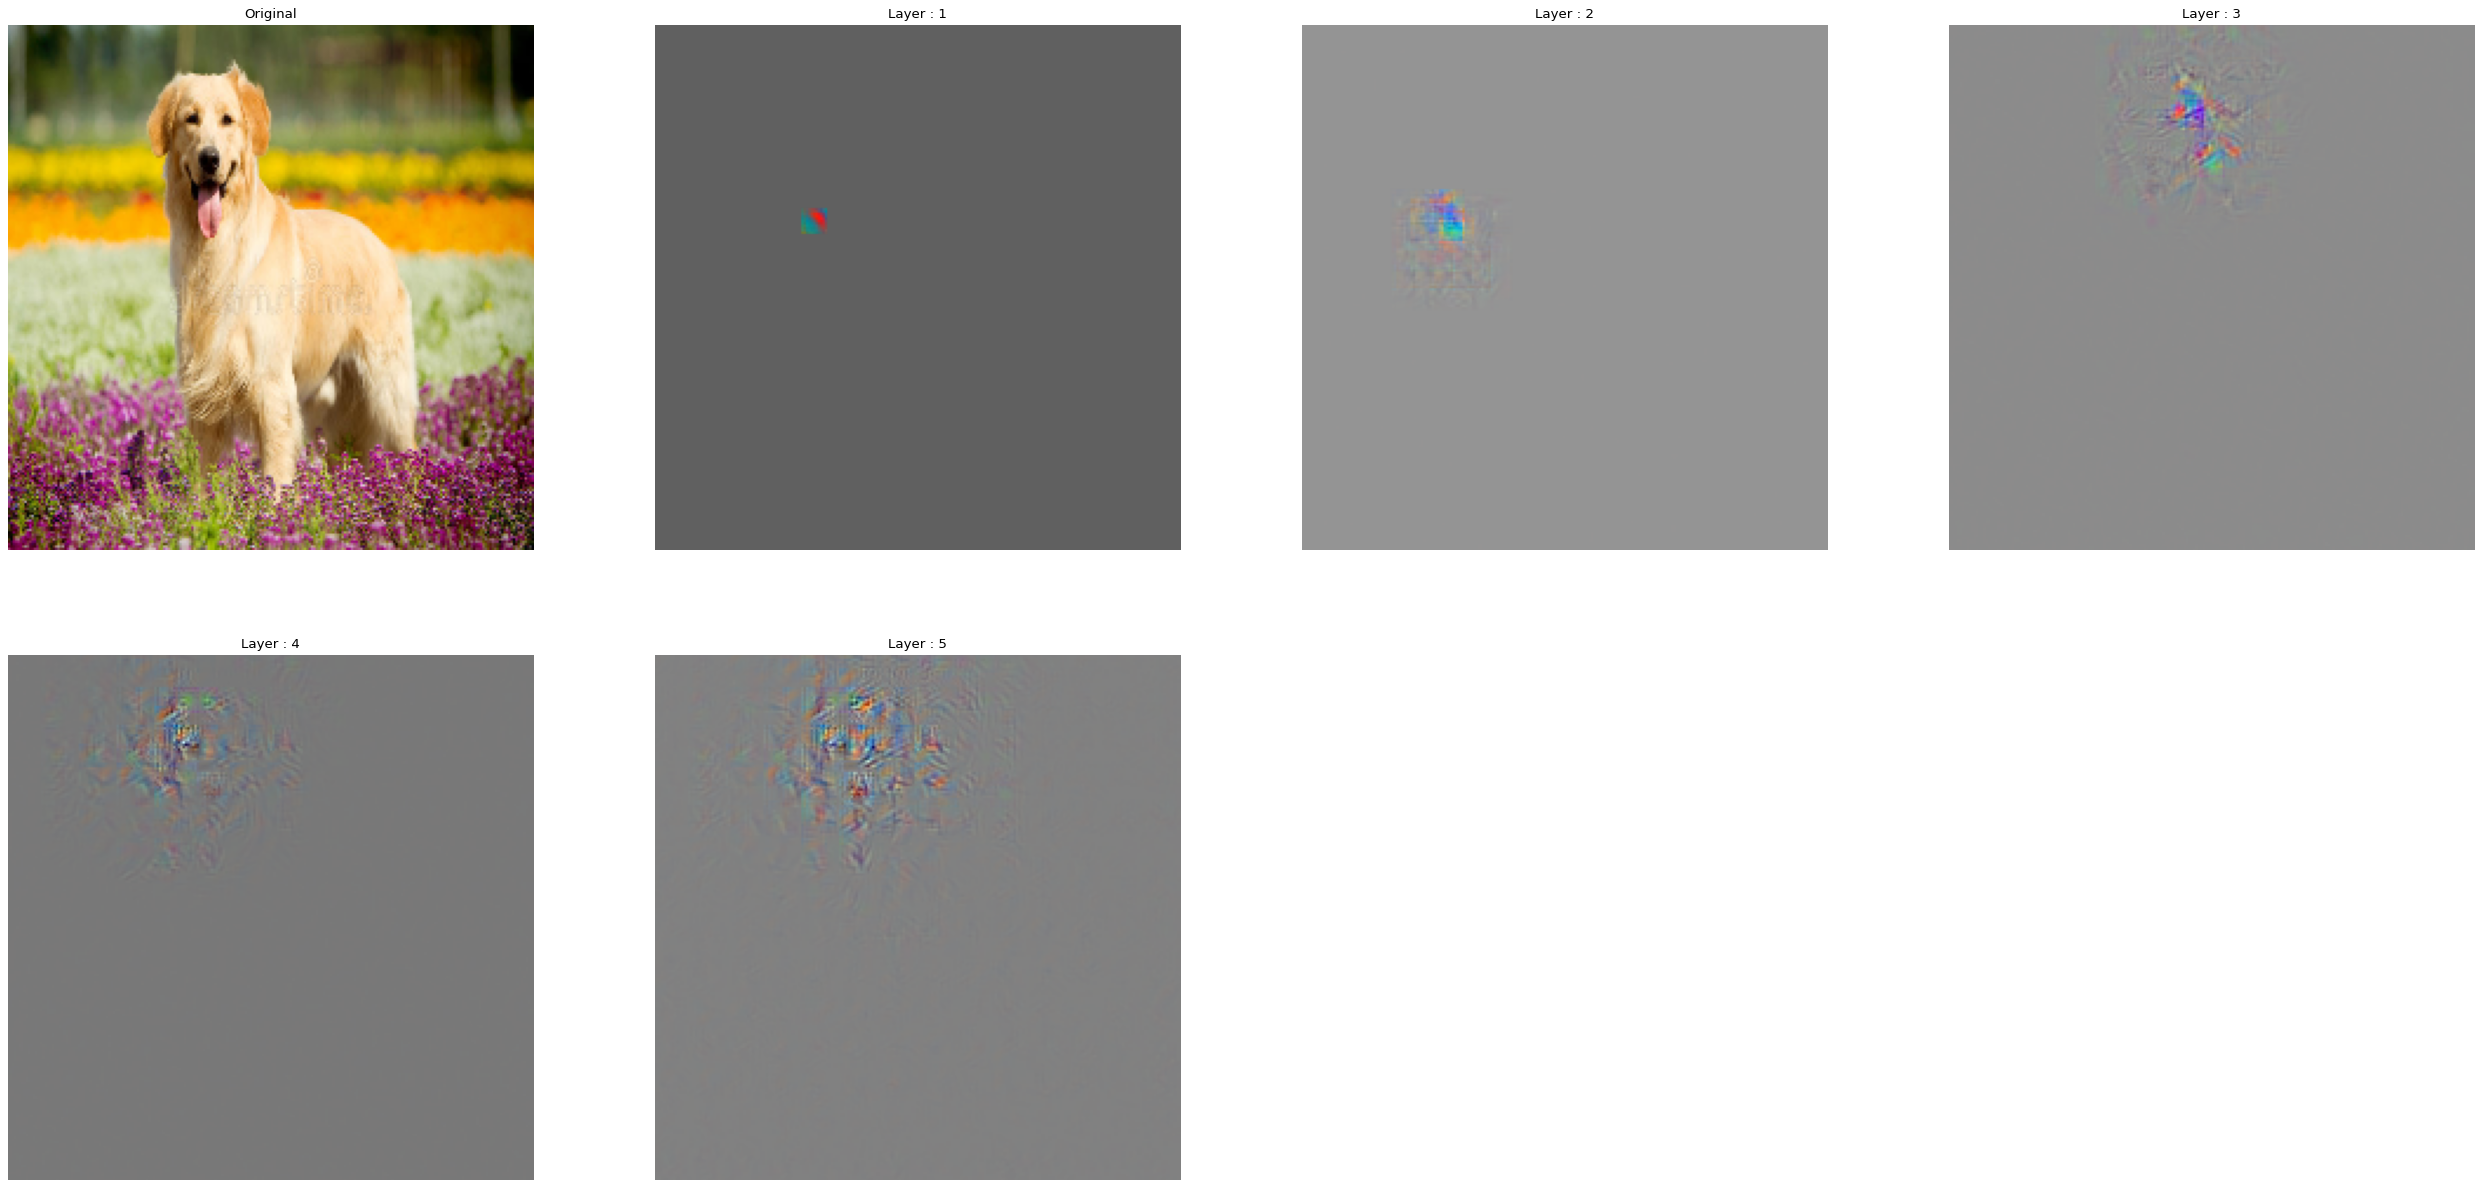

In [17]:
img_orig = cv2.imread('imgs/dog.jpg')
visualise_for_image(img_orig)

Predicted: ('985', 'daisy')


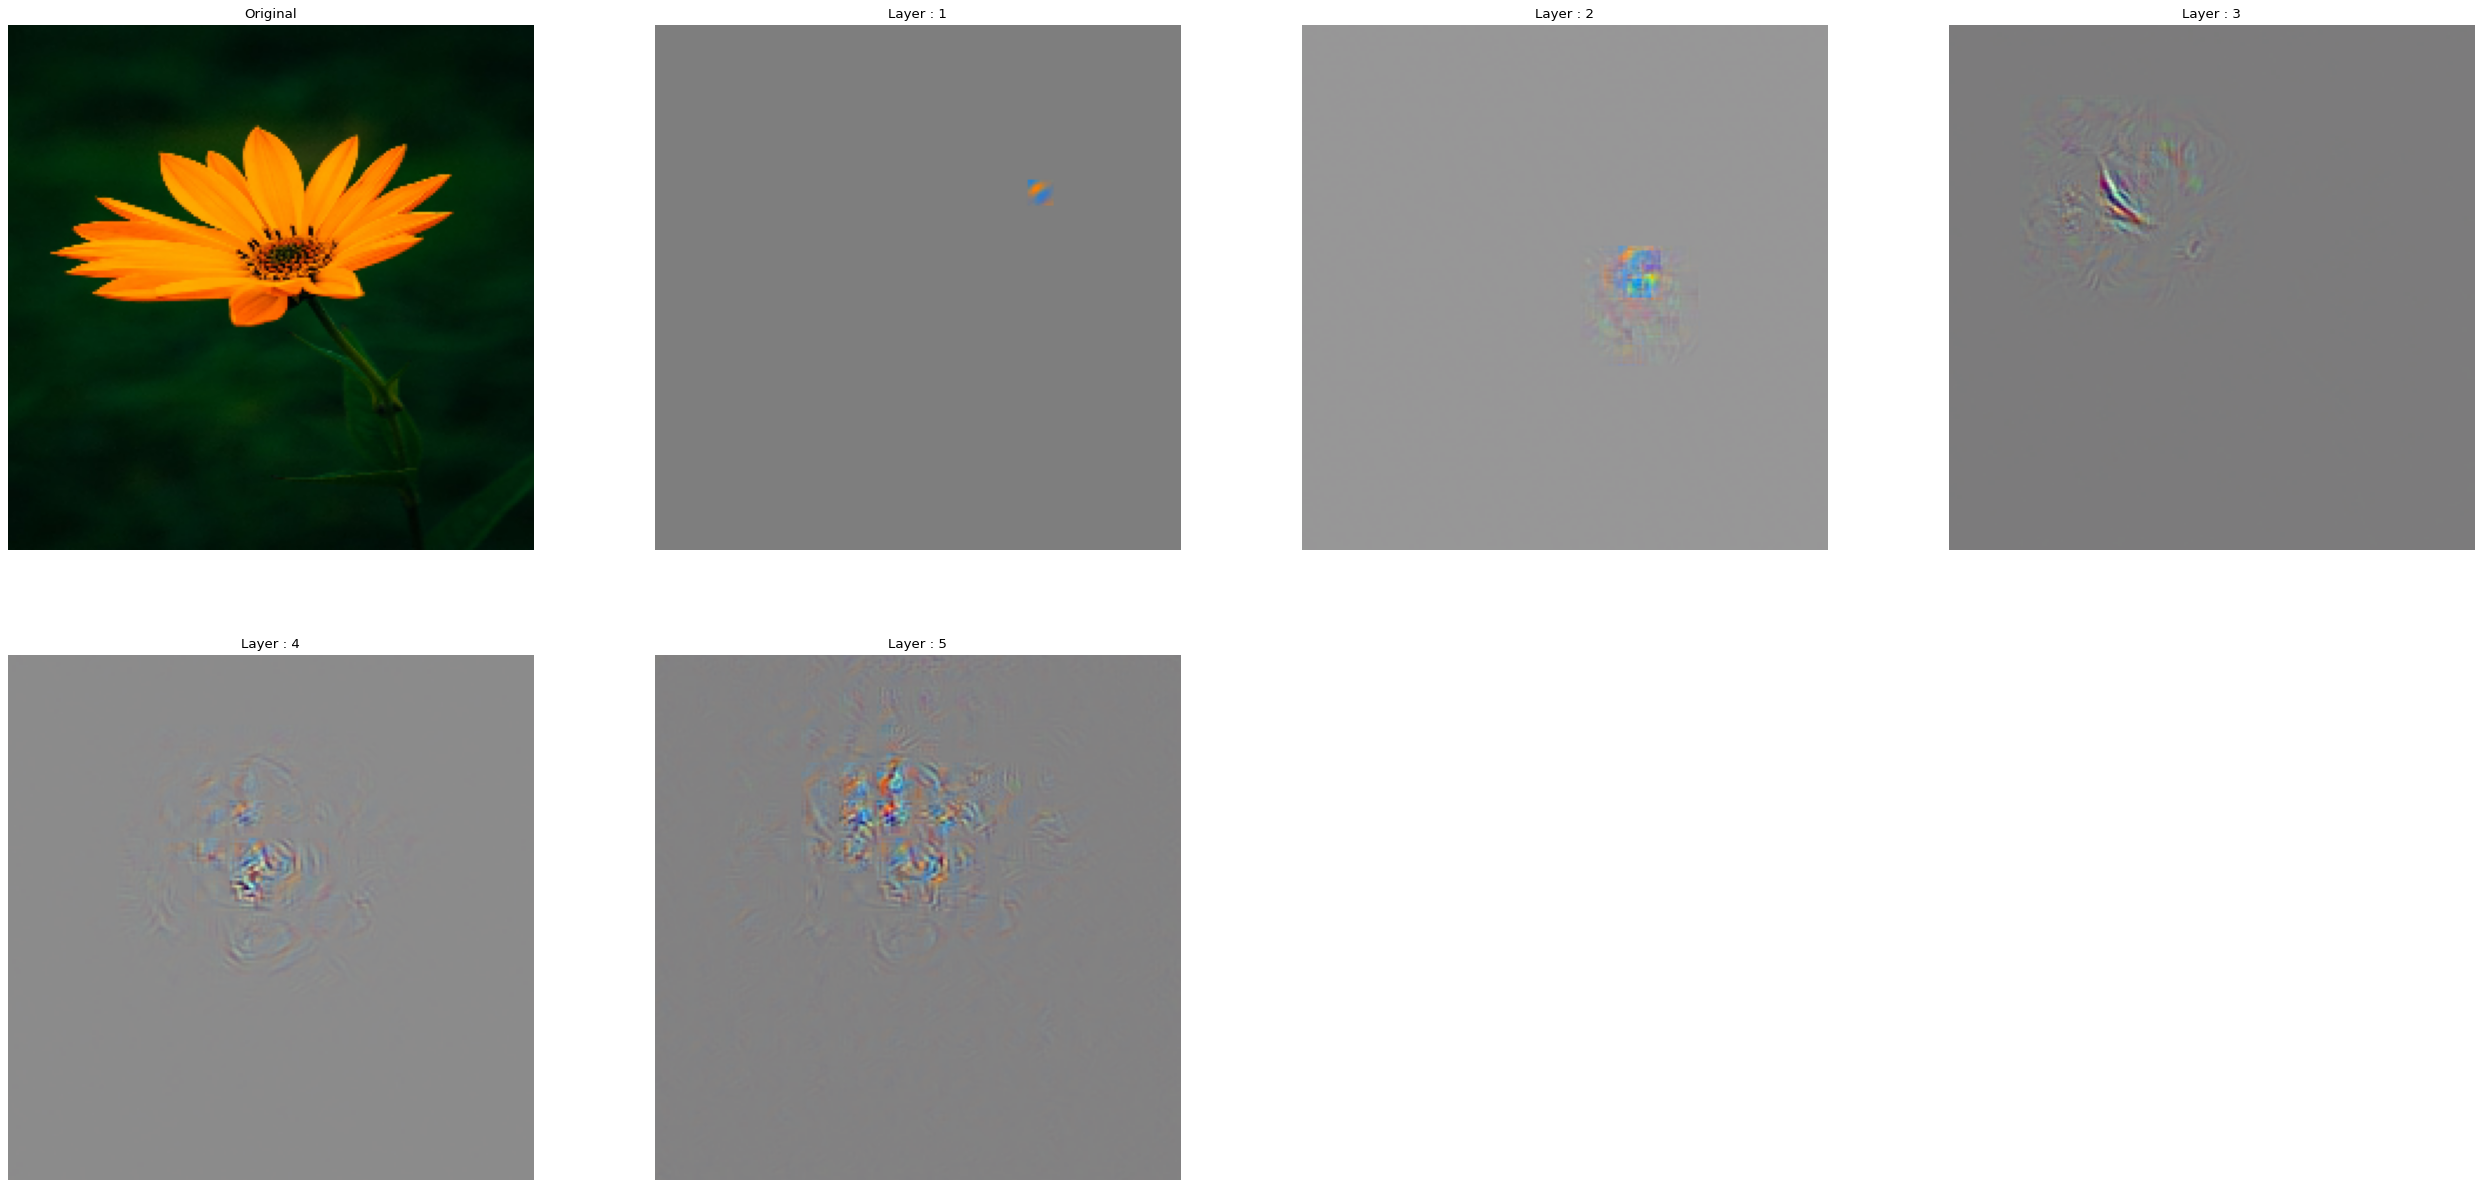

In [14]:
img_orig = cv2.imread('imgs/flower.jpeg')
visualise_for_image(img_orig)